# Select wildfire burn area predictors, train a classifier, & make predicitons. 

- This will be done using the Lasso (L1 Norm), which will be implemented using sk-learn sklearn.linear_model.Lasso()
- The Lasso() has a single hyperparameter, $\alpha$, which I will selected using nested leave-one-out cross validation via sklearn.model_selection.LeaveOneOut, the best model will be chosen using sklearn.model_selection.GridSearchCV()
- Environmental variables to be used as features include near surface temperature (tas), Total Precipitation (Tp), RH% (hurs), near surface wind speed (ScfWind), vapor pressure deficit (VPD), near surface specific humidity (huss), evaporation (evspsbl), total soil moisture content (mrso), and latent heat flux (hfls).  
- All reanalysis data used to train the model as well as CMIP5 output to project are monthly means or totals. For training and predictions, seasonal mean and totals of the predictors will be created, including lagged predictors. $e.g.$ winter precip will be calculated and used to predict summer wildfire burn area.  


#### TODO: 
- If you can't get the skill up
- Limit the number of predictors based on those with a descent correlation
- Try a smaller area? 

In [1]:
%matplotlib inline
import numpy as np
from netCDF4 import Dataset
import os
#%config InlineBackend.figure_format = 'svg' # For higher resolution figures
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import model_dictionary as md # Modules I have written 
from sklearn import preprocessing # For scaling data 
import met_spread_utils as utils # Script full of methods required for this analysis. 
from shapely.geometry import Polygon, Point
import geopandas

In [2]:
use_plant_mask = False
use_atmos_mask = False
predictors = ["t2m", "tp", "si10", "RH", "slhf", "VPD", "mrso", "e"] # all variables for prediction
plant_vars = ['pr', 'mrso','hfls', 'evspsbl'] # plant centric for prediction, CMIP5 names 
atmos_vars = ['tas', 'VPD', 'hurs', 'sfcWind'] # atmos centric prediction, CMIP5 names

In [3]:
# Set important path
CMIP5_dir = os.path.join("..", "Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")
era_dir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
fire_file = os.path.join("..","Data","Fire", "MTBS", "bailys_division_acres_burned.csv")

# Get the desired burn area data and make a time series

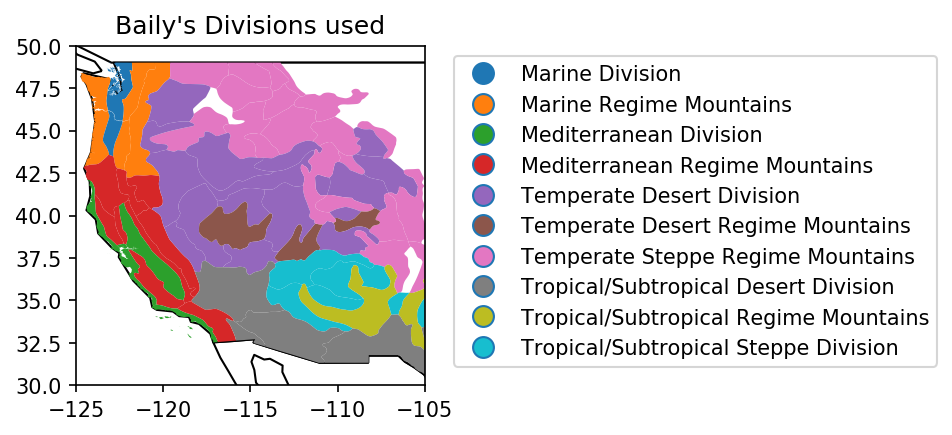

In [4]:
# Load US ecoregions and plot the united states land mass together
eco_dir = os.path.join("..", "Data", "LandCover", "eco-us-shp")
eco_shp = geopandas.read_file(eco_dir)
eco_shp = eco_shp.to_crs({'init': '+init=epsg:4326'})
# For political borders
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.to_crs({'init': '+init=epsg:4326'})

# Hand craft (later to be set options) the desired spatial regime for burn
# area and met fields. 
if True :
    # Western US divisions
    desired_divisions = ["Temperate Steppe Regime Mountains", 
                         "Marine Regime Mountains", 
                         'Marine Division',
                         "Mediterranean Regime Mountains",
                         "Mediterranean Division",
                         'Temperate Desert Division',
                         "Tropical/Subtropical Steppe Division",
                         'Tropical/Subtropical Desert Division',
                         'Tropical/Subtropical Regime Mountains',
                         'Temperate Desert Regime Mountains',
                        ]
if False :
    # California divisions
    desired_divisions = ["Mediterranean Regime Mountains", "Mediterranean Division"]
    
# Make a mask of the desired divisions
division_mask = eco_shp.DIVISION.isin(desired_divisions)
eco_shp_subset = eco_shp.loc[np.array(division_mask),:].copy()

# Show the selected divisions 
f, ax = plt.subplots(1, figsize=(3, 3), dpi=150)
base=world.plot(ax=ax, color="white", edgecolor="black")
ax1 = eco_shp_subset.plot(ax=base,column='DIVISION', legend=True)
ax.set_xlim(left=-125, right=-105)
ax.set_ylim(bottom=30, top=50)
plt.title("Baily's Divisions used")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1, 1, 1.5, 0.0))
plt.show()

Index(['Temperate Steppe Regime Mountains', 'Marine Regime Mountains',
       'Temperate Desert Division', 'Tropical/Subtropical Desert Division',
       'Tropical/Subtropical Steppe Division',
       'Tropical/Subtropical Regime Mountains',
       'Mediterranean Regime Mountains', 'Mediterranean Division',
       'Temperate Desert Regime Mountains', 'Marine Division'],
      dtype='object')


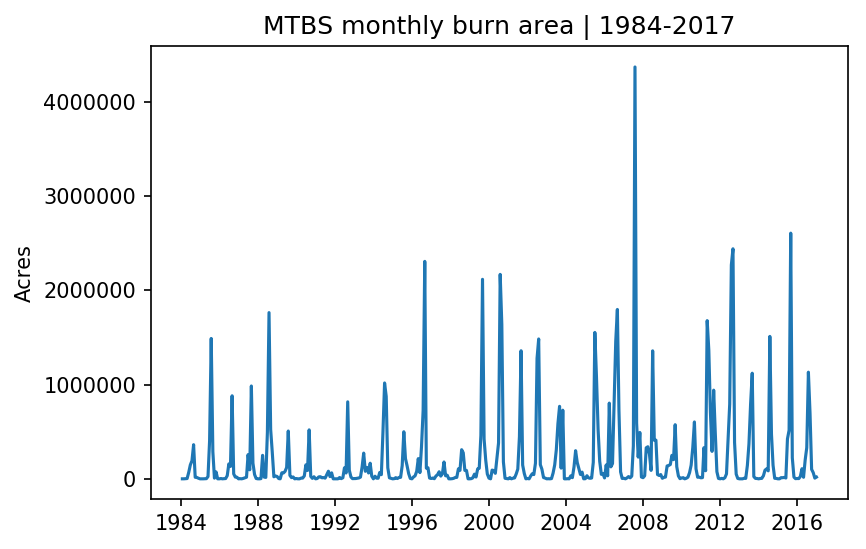

In [5]:
# Read in burn area, in acres
fire_df = pd.read_csv(fire_file)

# subset by the desired divisions
division_mask = fire_df.columns.isin(desired_divisions)
print(fire_df.columns[division_mask])
fire_df_subset = fire_df.loc[:,np.array(division_mask)].copy()

# MTBS data start Jan 1984, are monthly, and end in 2017. Make
# a time array date_range that matches this. 
time_mtbs = pd.date_range("1984-01-01", periods=len(fire_df), freq="M")

# Sum the burn area in these divisions (columns)
BA=fire_df_subset.sum(axis=1).copy()
#BA.set_index(time_mtbs)

plt.figure(dpi=150)
plt.plot(time_mtbs, BA)
plt.title("MTBS monthly burn area | 1984-2017")
plt.ylabel("Acres")
plt.show()

# Get Baily's region corrosponding meteorology grids
- We make the assumption that the burn area in the baily's regions mapped above is driven my meteorology over the same spatial region. ERA-interim met (for training) and CMIP5 (for future projections) have been gridded to a common grid and I have figured out what grid boxes overlap what Baily's divisions. 
- The following code gets masks for each baily's division within the desired_divisions array. This allows us to subset the gridded meteorology for only the grid boxes that overlap the spatial area of interest. The spatial overlaps and mask creation was done with Python/create_ecoregion_overlap_masks.ipynb

In [6]:
# I need to know what met grid cells to keep with these divisions. Find which ones overlap. 
grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(grid_division_masks_file, 'r')

grid_lat = nc.variables['lat'][:].data
grid_lon = nc.variables['lon'][:].data

# Use any division grid to set an empty array 
division_mask = np.zeros(shape=nc.variables["Marine Regime Mountains"][:].data.shape)

for division in desired_divisions :
    
    division_key = division.replace("/", " ")
    # Where variables are greater than 0, that means that grid box
    # overlaps the division. That means anywhere where
    # division_mask > 0 is a grid box we want. 
    division_mask += nc.variables[division_key][:].data
    
# setup a lat long mask, because we do not want grid boxes for the high latitude
# 'Marine Regime Mountains'
lat_mask = grid_lat > 50. 
division_mask[lat_mask,:] = 0

### The number of Baily's divisions a given Met grid box overlaps. 

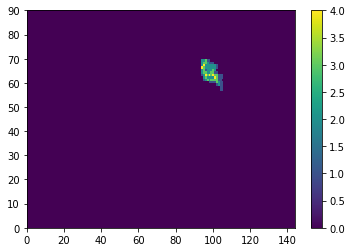

In [7]:
plt.figure()
plt.pcolor(division_mask)
plt.colorbar()
plt.show()

Same as above but binary. 

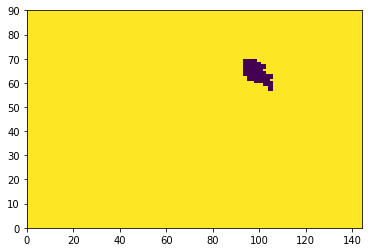

In [8]:
# To pass to np.ma.masked_array
spatial_mask = division_mask == 0
plt.figure()
plt.pcolor(spatial_mask)
plt.show()

Function for getting era_nc_vals. Will be moved out of notebook when development is complete

In [9]:
def get_era_nc_vals(var, spatial_mask, spatialMean=False, startYear=1983):
    """
    This function will be for loading a particular nc file, which will be spatially subset.
    The data loaded are from the merged_t_COMMON_GRID directory. These data have been
    regridded from thier native resolution using cdo remapbil. 
    
    TODO: Add "endyear" as an argument in addition to "startyear" as new MTBS fire data is 
    TODO: going to require going further back in time to train the model. 
    
    Parameters
    ----------
        var : str, The variable (and file name) of the ECMWF era-interim data to be 
              loaded. 
        spatial_mask : numpy array, where equal to 1 are locations to keep, where equal 
                       to 0 are grid points to mask. 
        spatialMean : Boolean, if False (default) a spatial mean of the era-interim data
                      is not taken and the data are returned on a t,lon,lat grid. 
                  
    Return
    ------
        valsCut : The chosen "var" as a ndarray(t, lat, lon) or if spatialMean = True
                  ndarray(t). 
        t_monCut : pd.date_range describing the t axis of valsCut. 
        lonCut : longitude ndarray
        latCut : latitude ndarray
    
    """
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1983-2017.nc" 

    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! 
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 420):
        # Convert to pandas time array, on the assumption t[0]=startYear-01-01 the data
        # being monthly. Defualt files are 1983-2017.  
        t_mon = pd.date_range(str(startYear)+"-01-01", periods=len(t), freq="M")
    else:
        # there should always be 420 months in these data (35 years of data times 12)
        raise ValueError('Error in number of months for file: '+ f + " 420 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # take a spatial mean? 
    if spatialMean:
        vals_masked = np.ma.mean(vals_masked, axis=(1,2))
    
    return vals_masked, t_mon, lon, lat

### Load desired ERA-Interim reanalysis
- Load each variable, take the spatial mean for the spatial_masks shown above and place in a dataframe where each row is a month and each column is a variable, each cell is a monthly mean value for the area. 

In [10]:
predictorDict = {}

for var in predictors:
    
    predictorDict[var], t, lon, lat = get_era_nc_vals(var, spatial_mask, spatialMean=True)

# Features used to estimate the target function    
X_monthly = pd.DataFrame(predictorDict, index=t)

In [11]:
X_monthly.iloc[0:5,:]

,t2m,tp,si10,RH,slhf,VPD,mrso,e
1983-01-31,277.131775,0.005258,3.839690,70.977388,-4.073215e+06,256.556404,667.301286,-0.001614
1983-02-28,278.790602,0.006551,4.042103,69.640710,-5.339471e+06,298.816778,690.220440,-0.002120
1983-03-31,280.951858,0.006803,4.437872,66.930437,-7.498069e+06,384.356591,707.031549,-0.002982
1983-04-30,282.504105,0.003827,4.331579,56.663805,-9.827519e+06,559.737273,699.289051,-0.003913
1983-05-31,287.799991,0.003486,4.219247,53.701648,-1.171328e+07,841.885817,682.660337,-0.004680


### Change units of some ERA-Interim data to match CMIP5 output

#### Evaporation
- evaporation, e, is m mon$^{-1}$, want to match evspsbl is $kgm^{-2}s^{-1}$
- precipitation

$$evspsbl_{era-interim} = e(\frac{m}{mon})\times1000(\frac{kg}{m^{3}})\times\frac{1mon}{30day}\times\frac{1day}{86400s}$$

#### Total Precipitation
- Total precip, tp, is m mon$^{-1}$, want to match $tp_{CMIP5}$ ($kgm^{-2}s^{-1}$)

$$tp^{'} = tp(\frac{m}{mon})\times1000(\frac{kg}{m^{3}})\times\frac{1mon}{30day}\times\frac{1day}{86400s}$$


#### Surface latent heat flux
- ERA-interim slhf as J $m^{-2}$ (very negative for the Gulf Stream)
- CMIP5 : hfls (surface upward latent heat flux) as W $m^{-2}$ (very positive over Gulf Stream)

$$W=\frac{J}{s}=kg m^{2} s^{-1}$$


$$hfls_{era-interim} = slhf(J m^{-2}) \times \frac{1}{mon} \times \frac{mon}{s} = slhf(J m^{-2})\times \frac{1mon}{30day}\times\frac{1day}{86400s}$$

### TODO: 
- Do I need to account for different number of days in months?
- Get rid of the factor of two after new fixed data are ready. 

In [12]:
def m_to_mass_flux(tp_m) :
    """
    This function takes mean total precipitation in meters [m] and converts to a mass flux. 
    https://confluence.ecmwf.int/pages/viewpage.action?pageId=65218804
    Incoming tp_m argument must have units of mean m/day. Multiplication by the density
    of water, 1 mon per 30 days, 1 day per 86400 seconds are used to obtain units
    of kg m**-2 s**-1, the so-called tp_prime value that is returned. 
    Will work anytime meters of water per month needs to be converted to kg/m**2/s
    """
    
    density = 1000. # kg m**-3
    #nYears = len(np.arange(1983,2017+1))
    #days_per_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    #seconds_per_month = days_per_month * 24. * 60**2
    # Same length as tp_m
    #seconds_per_all_months = np.repeat(seconds_per_month, nYears) 
    seconds_per_day = 86400. 
    tp_prime     = tp_m * density / seconds_per_day / 2. # temp factor of 2? 
    
    return tp_prime

def J_flux_to_W_flux(slhf) :
    """
    https://confluence.ecmwf.int/pages/viewpage.action?pageId=65218804
    Converts a flux of J m**-2 month**-1 to W m**-2 month**-1
    """
    #nYears = len(np.arange(1983,2017+1))
    #days_per_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    #seconds_per_month = days_per_month * 24. * 60**2
    #seconds_per_all_months = np.repeat(seconds_per_month, nYears)
    # The minus one is to make the sign of the flux over the gulf current match
    seconds_per_day = 86400. 
    hfls_era_interim = slhf / seconds_per_day / 2. * -1 # temp factor of dividing by 2. 
    
    return hfls_era_interim

In [13]:
tp_mass_flux = m_to_mass_flux( np.array(X_monthly["tp"].copy()) )
evspsbl = m_to_mass_flux( np.array(X_monthly["e"].copy()) ) * -1.
hfls = J_flux_to_W_flux( np.array(X_monthly["slhf"].copy()) )

In [14]:
# Replace columns with updated versions
X_monthly.loc[:, "tp"] = tp_mass_flux
X_monthly["hfls"] = hfls # new!
X_monthly["evspsbl"] = evspsbl # new! 

In [15]:
# remove slhf, we do not want it
X_monthly = X_monthly.drop(columns=["slhf","e"]).copy()
X_monthly.iloc[0:5,:]

,t2m,tp,si10,RH,VPD,mrso,hfls,evspsbl
1983-01-31,277.131775,0.000030,3.839690,70.977388,256.556404,667.301286,23.571846,0.000009
1983-02-28,278.790602,0.000038,4.042103,69.640710,298.816778,690.220440,30.899714,0.000012
1983-03-31,280.951858,0.000039,4.437872,66.930437,384.356591,707.031549,43.391601,0.000017
1983-04-30,282.504105,0.000022,4.331579,56.663805,559.737273,699.289051,56.872216,0.000023
1983-05-31,287.799991,0.000020,4.219247,53.701648,841.885817,682.660337,67.785166,0.000027


In [16]:
# Finally, make the names of the era-interim variables match the names
# in CMIP5 output. After this step, the units and names should math. 
X_monthly.rename(columns={"t2m":"tas", "tp":"pr","si10":"sfcWind", "RH":"hurs"}, inplace=True)
X_monthly.iloc[0:5,:]

,tas,pr,sfcWind,hurs,VPD,mrso,hfls,evspsbl
1983-01-31,277.131775,0.000030,3.839690,70.977388,256.556404,667.301286,23.571846,0.000009
1983-02-28,278.790602,0.000038,4.042103,69.640710,298.816778,690.220440,30.899714,0.000012
1983-03-31,280.951858,0.000039,4.437872,66.930437,384.356591,707.031549,43.391601,0.000017
1983-04-30,282.504105,0.000022,4.331579,56.663805,559.737273,699.289051,56.872216,0.000023
1983-05-31,287.799991,0.000020,4.219247,53.701648,841.885817,682.660337,67.785166,0.000027


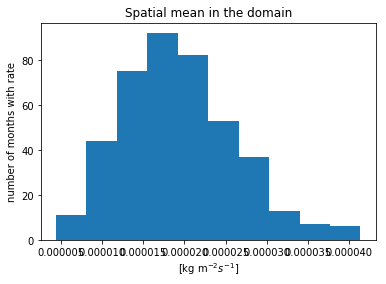

In [17]:
#plt.figure()
#plt.plot(X_monthly["pr"].values, tp_mass_flux)
#plt.xlabel("pr [m]")
#plt.ylabel("pr [kg m$^{-2}s^{-1}$]")
#plt.suptitle("ERA-Interim total precipitation (tp) meters to mass flux ratio")
#plt.title("(Should be linear)")
#plt.show()

plt.figure()
plt.hist(tp_mass_flux)
plt.xlabel("[kg m$^{-2}s^{-1}$]")
plt.title("Spatial mean in the domain")
plt.ylabel("number of months with rate")
plt.show()

### Now that the variables are all consistent, cut to use only those specified

In [18]:
if use_plant_mask :
    X_monthly = X_monthly.loc[:, plant_vars].copy()
    predictors = X_monthly.columns.values
    
if use_atmos_mask :
    X_monthly = X_monthly.loc[:, atmos_vars].copy()
    predictors = X_monthly.columns.values
    
predictors

['t2m', 'tp', 'si10', 'RH', 'slhf', 'VPD', 'mrso', 'e']

In [19]:
X_monthly

,tas,pr,sfcWind,hurs,VPD,mrso,hfls,evspsbl
1983-01-31,277.131775,0.000030,3.839690,70.977388,256.556404,667.301286,23.571846,0.000009
1983-02-28,278.790602,0.000038,4.042103,69.640710,298.816778,690.220440,30.899714,0.000012
1983-03-31,280.951858,0.000039,4.437872,66.930437,384.356591,707.031549,43.391601,0.000017
1983-04-30,282.504105,0.000022,4.331579,56.663805,559.737273,699.289051,56.872216,0.000023
1983-05-31,287.799991,0.000020,4.219247,53.701648,841.885817,682.660337,67.785166,0.000027
1983-06-30,291.676101,0.000020,4.011679,54.038786,1080.733783,656.486715,72.891116,0.000029
1983-07-31,294.761489,0.000019,3.955563,52.095731,1359.044814,637.945421,68.402271,0.000027
1983-08-31,295.550135,0.000023,3.199268,56.417432,1259.668215,622.785574,68.101925,0.000027
1983-09-30,291.874383,0.000018,3.786771,54.564939,1045.230831,612.771641,53.074122,0.000021
1983-10-31,286.800893,0.000020,3.279274,63.670972,602.805454,620.192197,42.403586,0.000017


### Setup forecasting summer burn area using seasonal (varying t-lag) predictors and calculating summer burn area

#### Seasons to aggregate features
- summer 
- spring 
- winter  
- temperature

TODO: Ths needs to be a function that will work the same way for CMIP5 data 

In [20]:
# Create summer burn area time series
fire_years  = np.sort(np.unique(time_mtbs.year))
nYears      = len(fire_years)

# Create season masks (first month last month of season). Each season gets its own 
# column in the features DataFrame.
# NOTE: Make sure to not use months after wildfires in a given year, e.g. 
# NOTE: December, unless set to the year before # Make sure to not use months 
# NOTE: after wildfires in a given year, e.g. December, unless set to the year before 
month = pd.Series(time_mtbs.month)
seasons = {"winter":[1,2], 
           "spring":[3,4,5], 
           "summer":[6,7,8]}

# Make a dictionary to store predictors for each variable for each season 
# of interest. 
variables = np.array( X_monthly.columns.copy() )
predictor_dict = {} # To store predictor information 

for pre in variables :
    for s in seasons.keys() :
        predictor_name = pre + "_" + s 
        predictor_dict[predictor_name] = np.zeros(nYears)

# Create a dictionary to store each season burn area
BA_dict = {} 
for s in seasons.keys() :
    BA_dict[s] = np.zeros(nYears)
    
# Loop through each year, assigning desired season predictor value 
# within each year 
for i in range(nYears):
        
    # Mask the year of interest, 0 through nYears  
    year_mask = fire_years[i] == time_mtbs.year
    #print(years[i])
        
    # Loop through seasons, within a year
    for s in seasons.keys():
        
        # Mask the months that fall into the current season of interest
        month_mask = month.isin(seasons[s])

        # combine to make a single mask
        tChunk = month_mask & year_mask 
        #print(time_mtbs[tChunk])
        
        # Burn area does not variable loop, just season
        BA_dict[s][i] = np.sum(BA[tChunk])

        # For each predictor variable, loop through taking relevant stat
        # TODO: consider an if statement to take sums vs. means of variables
        for pre in variables:
            k = pre + "_" + s
            predictor_dict[k][i] = np.mean(X_monthly.loc[time_mtbs[tChunk], pre].copy())

In [21]:
# Assign the summer values to a Features DataFrame. Here, I switch
# to some more math-ish language. 
era_features = pd.DataFrame(predictor_dict, index=fire_years)
BA_targets   = pd.DataFrame(BA_dict, index=fire_years)  
era_years    = fire_years.copy()

# This is now a nice Dataframe, so we can get rid of the outdated dict. 
del predictor_dict, BA_dict

In [22]:
BA_targets

,winter,spring,summer
1984,0.0,74189.0,701566.0
1985,0.0,27158.0,2177809.0
1986,3061.0,38191.0,1170293.0
1987,1533.0,32298.0,1336841.0
1988,1956.0,282402.0,2776889.0
1989,2595.0,205089.0,663949.0
1990,0.0,45770.0,755961.0
1991,23553.0,46618.0,132287.0
1992,0.0,27038.0,994799.0
1993,9553.0,153767.0,473972.0


In [23]:
era_features

,tas_winter,tas_spring,tas_summer,pr_winter,pr_spring,pr_summer,sfcWind_winter,sfcWind_spring,sfcWind_summer,hurs_winter,...,VPD_summer,mrso_winter,mrso_spring,mrso_summer,hfls_winter,hfls_spring,hfls_summer,evspsbl_winter,evspsbl_spring,evspsbl_summer
1984,276.702415,284.559572,294.026724,0.000018,0.000021,0.000019,3.858824,4.485705,3.684476,65.311259,...,1243.634214,672.710690,679.358650,627.257793,23.999438,51.522079,68.204627,0.000009,0.000021,0.000027
1985,274.782353,285.000536,294.528991,0.000015,0.000019,0.000014,3.645164,4.179557,3.676435,68.671626,...,1424.950376,666.010345,674.439924,618.255864,25.415973,54.717495,62.562723,0.000010,0.000022,0.000025
1986,278.704437,285.561546,294.416324,0.000030,0.000022,0.000016,4.047248,4.268945,3.710184,66.330827,...,1312.174485,662.503833,680.327776,625.840142,22.689130,54.118578,65.878624,0.000009,0.000022,0.000026
1987,276.973402,285.027386,293.873678,0.000025,0.000023,0.000017,4.023096,4.000154,3.715091,67.301338,...,1270.629290,666.402468,676.443816,632.068410,28.776163,55.627897,68.587882,0.000011,0.000022,0.000027
1988,276.374379,284.726423,294.644255,0.000017,0.000021,0.000016,3.873902,4.321334,3.623505,65.662760,...,1387.687928,649.058456,656.182574,608.120449,24.545448,51.761664,61.477842,0.000010,0.000021,0.000025
1989,275.368241,285.655330,294.213652,0.000020,0.000021,0.000016,3.885233,4.311816,3.795869,66.270988,...,1363.982189,624.405999,652.548370,611.739388,23.930071,49.246459,60.670593,0.000009,0.000020,0.000024
1990,277.294280,285.058647,294.555158,0.000027,0.000023,0.000015,4.279377,4.181957,3.820396,63.444043,...,1380.778336,627.540116,651.336928,611.352743,26.957572,51.181764,62.131278,0.000011,0.000020,0.000025
1991,277.511761,284.194972,293.967538,0.000017,0.000026,0.000018,3.557577,4.606572,3.625034,65.915199,...,1286.962747,625.616155,654.954583,617.506979,20.200297,52.360728,63.695775,0.000008,0.000021,0.000025
1992,278.224737,286.168165,293.948124,0.000026,0.000020,0.000017,3.713530,3.754141,3.640818,69.123720,...,1264.752287,661.872868,666.372598,622.728563,27.108832,56.108173,65.683154,0.000011,0.000022,0.000026
1993,275.614415,285.128820,293.340613,0.000028,0.000024,0.000018,3.780747,4.039643,4.103577,72.605872,...,1233.924930,668.739568,694.296888,644.436312,25.489388,53.341298,65.744947,0.000010,0.000021,0.000026


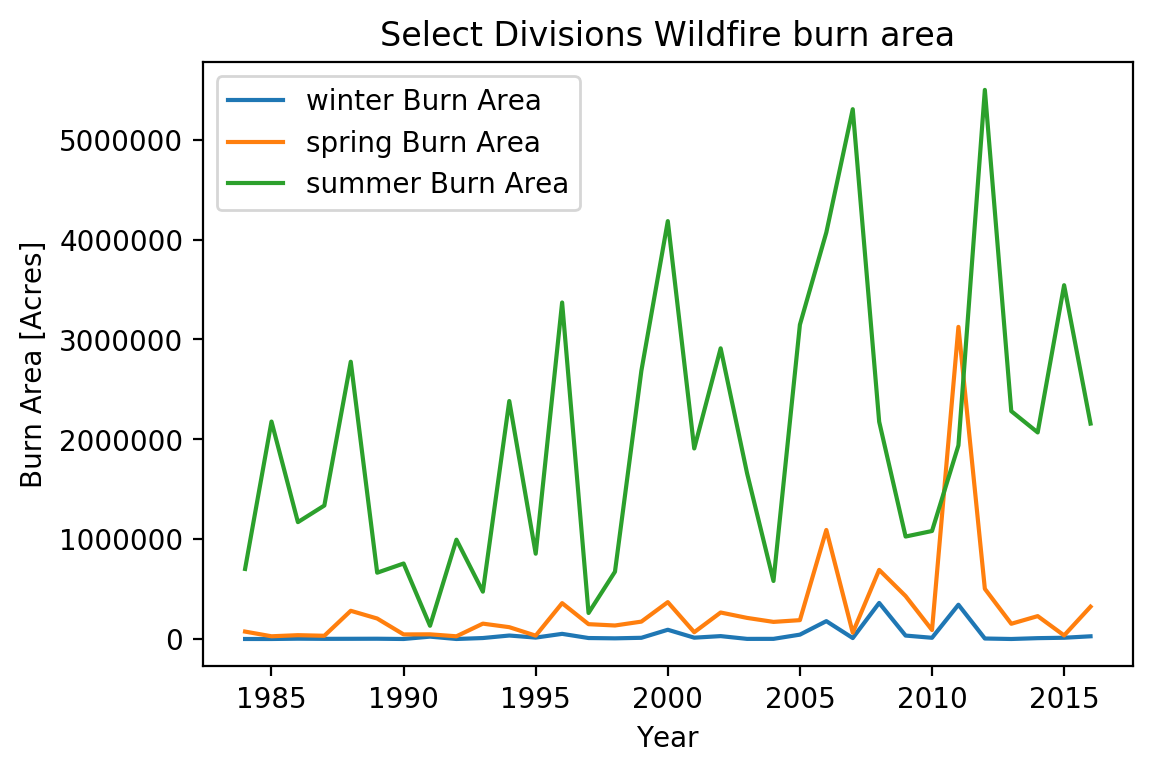

In [24]:
plt.figure(dpi=200., figsize=(6,4))
for target in BA_targets.columns :
    plt.plot(era_years, BA_targets[target], label=target + " Burn Area")
plt.title("Select Divisions Wildfire burn area")
plt.ylabel("Burn Area [Acres]")
plt.xlabel("Year")
plt.legend(loc="best")
plt.show()

## Standardize the features for summer burn area prediction

- This can be done using sklearn.preprocessing.StandardScaler
- The mean and standard deviation of the features needs to be saved in order for bias correcting CMIP5 output later. 

In [25]:
scaler = preprocessing.StandardScaler()
x = era_features.values.copy()
z = scaler.fit_transform(x)
print(z.mean(axis=0))
print(z.std(axis=0))

[-1.83960591e-14  5.86601474e-14 -6.91164298e-14 -2.63257429e-16
  1.10013009e-15  3.36431220e-17 -1.86887542e-15  3.11535309e-15
 -3.98670995e-15 -6.98094781e-16 -1.04041355e-15 -7.06841992e-15
 -2.32137542e-15 -1.94373137e-15  9.62193288e-16 -4.10046576e-15
  6.63105934e-15 -3.47533450e-15  2.08923787e-15 -4.38706310e-15
  1.85037171e-17 -2.28773229e-15  1.02947953e-15  2.37520441e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Implement a custom cross validation scheme that minimizes leave one out sample error
- Use nested so that there is no data snooping and so my classifier does not estimate too high a value. 
- Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. When alpha = 0 Lasso is the same as OLS regression. And with this many features, it will FOR SURE be overfit. 
````Python 
for alpha value in a range(alphas) : 
    for leaving a year out: (1984:2016):
        leave_one_out_model = Lasso(alpha, these years of targets and predictors)
        
     Calculate mean error for this alpha
````

In [26]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [27]:
# This is the target ['winter', 'spring', 'summer']
y = np.log(BA_targets['summer'].values.copy())

In [28]:
linear_model = LinearRegression()
_ = linear_model.fit(z,y)
linear_model.score(z,y)

0.948508669026553

In [29]:
pd.DataFrame({"linear reg coef":linear_model.coef_}, index=era_features.columns.values)

,linear reg coef
tas_winter,0.350010
tas_spring,-1.531038
tas_summer,2.863362
pr_winter,-0.677224
pr_spring,0.537100
pr_summer,-0.710758
sfcWind_winter,0.300495
sfcWind_spring,-0.235570
sfcWind_summer,0.313610
hurs_winter,0.174580


TODO: get the nested cross validation working using LassoCV

#### Create an alpha range to span and calculate error associated with estimating year left out. 
- Research what you want these curves to look like in terms of performance from first principles. 
- TODO: Make all cross validation methods into a class. 

In [30]:
# Use the Lasso to fit. Use built in LassoCV for easy LeaveOneOut
# cross validation. 
alphas = np.arange(0.01, 4., 0.01)
lasso_model = LassoCV(alphas=alphas, cv=LeaveOneOut(), max_iter=4000)
lasso_model.fit(z,y)
print(lasso_model.alpha_)
pd.DataFrame({"LassoCV coefs":lasso_model.coef_}, index=era_features.columns.values)

0.18000000000000002


,LassoCV coefs
tas_winter,0.000000
tas_spring,0.000000
tas_summer,0.128478
pr_winter,-0.000000
pr_spring,-0.000000
pr_summer,-0.000000
sfcWind_winter,0.000000
sfcWind_spring,-0.000000
sfcWind_summer,-0.000000
hurs_winter,-0.000000


TODO: table of coefs and mean trends from CMIP5 model would be very powerful hear, then, a final column as the number of acres increse that represents by 2050 and 2100

In [31]:
def show_model_skill(y, x, z, model, years) :
    """
    Predict historical values using optimal alphas.
    plots the following:
        1) model coeficients
        2) y vs. y_hat time series
        3) y vs. y_hat 1:1
        4) model residuals
        
        # TODO: Make into a class. 
        
    Parameters
    ----------
    target : The values being predicted as a pd.DataFrame
    y : the target values as an array
    Z : the features used to predict the target as a pd.DataFrame
    alpha_best : the alpha with the lowest leave_one_year_out_cv() out 
                 of sample error. 
    years : ndarray, the years the desribe rows of Z and indicies of y. 
    
    """
    
    # Make prediction
    y_hat = model.predict(z)
    
    # Setup figure 
    fig = plt.figure(dpi=200, figsize=(10,10))
    
    fig.suptitle("regression summary", fontsize=14)
    
    ##########################################
    # Show the coeficients for the model_best
    ##########################################
    plt.subplot(2, 2, 1)

    plt.bar(x.columns.values, model.coef_)
    plt.axhline(y=0, c="k", linestyle="--")
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coefficients")
    plt.title("Feature coefs for least square error model, $\\alpha$=" + str(np.round(model.alpha_, 4)))

    ########################################
    # Plot obs and modeled values for both
    ########################################
    r2 = np.round(metrics.r2_score(y_true=y, y_pred=y_hat),4)
    plt.subplot(2, 2, 2)
    plt.plot(years, y, label="observation")
    plt.scatter(years, y, s=15)
    plt.plot(years, y_hat, label="model, r$^{2}$=" + str(r2), linestyle=":")
    plt.ylabel("log$_{10}$(burn area)")
    plt.legend()
    plt.title("Time series of data and estimates")

    ########################################
    # Plot observations vs. modeled values
    ########################################
    x1 = np.linspace( np.min([y, y_hat]), np.max([y, y_hat]) )
    r = np.round(np.corrcoef(y, y_hat)[0][1], 3)

    plt.subplot(2, 2, 3)
    plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
    plt.scatter(y, y_hat, c=years)
    plt.xlabel("Observation")
    plt.ylabel("Predicted")
    plt.title("Observation vs. predicted values | r="+str(r))

    ########################################
    # Plot residuals 
    ########################################
    zero = np.zeros(len(years))
    
    plt.subplot(2, 2, 4)
    plt.scatter(years, y-y_hat, c=years)
    plt.plot(years, zero, color="k", linestyle=":")
    plt.ylabel("log$_{10}$(burn area m$^{2}$)")
    plt.title("Model residuals")
    plt.colorbar()
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()

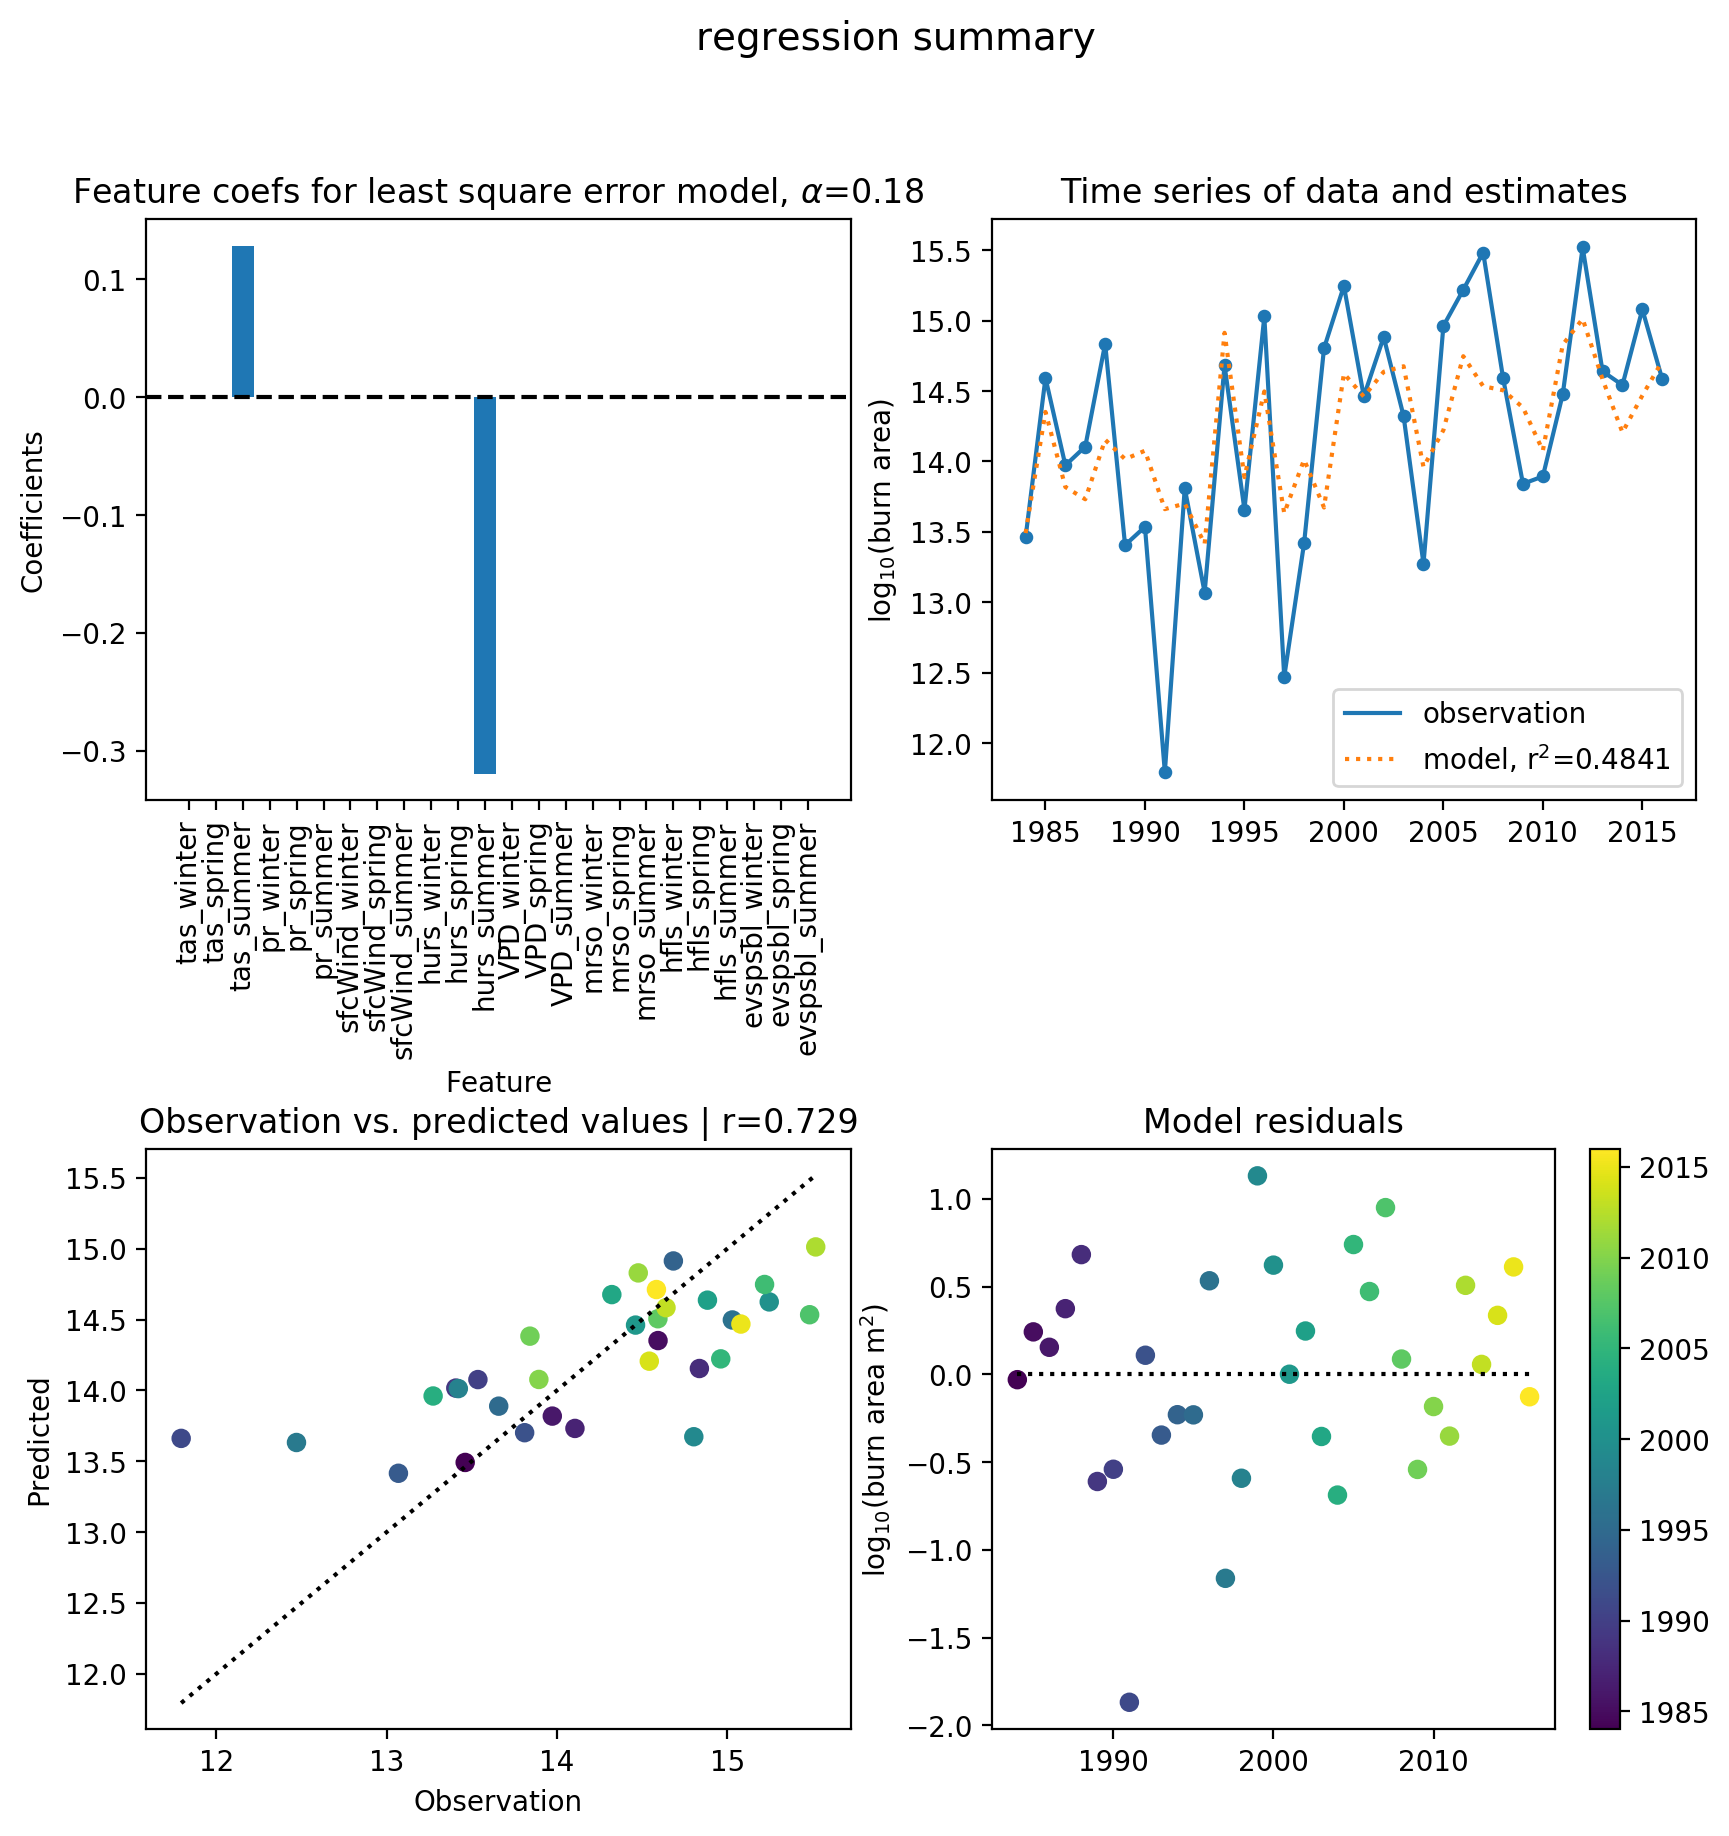

In [32]:
show_model_skill(y, era_features, z, lasso_model, fire_years)

In [33]:
# TODO: Make an array of the CMIP5 vars that are needed based on non zero coefs
# TODO: from the Lasso. 
training_features = era_features.columns.values.copy()
features_used_mask = np.abs(lasso_model.coef_) > 0.
features_used = training_features[features_used_mask]
cmip_features = []
for i in range(len(features_used)) : 
    cmip_features.append( features_used[i].split("_")[0] ) 
cmip_features

['tas', 'hurs']

### Show the coeficients and performance of the best Lasso regressions
#### TODO:
* This is where it would make sense to save out these models, the coefs represent feature importance, here I can use these features and explicitly explore :

    1) The future variability/spread in the different important features
    
    2) The year a majority of CMIP5 models leave the range used to train the relationship

# Predict future burn area using CMIP5 data from RCP45 and RCP85
- As many models as possible. 

In [34]:
def get_cmip5_nc(var, rcp, model, spatial_mask, spatial_mean=False):
    """
    This function will be for loading a particular CMIP5 NetCDF file, which will be spatially subset 
    by this function. These CMIP5 model output to be loaded have been regridded to the "Common grid" 
    using $ cdo remapbil. Defualts to taking the spatial mean of all global data for the var argument. 
    Change area loaded using the minX, maxX, etc. arguments. 
    
    Parameters
    ----------
        var : str, The CMIP5 variable name to be loaded. File names match variable names. 
        rcp : str, "45" or "85", refers to representative concentration pathway. 
        model : The name of the model that created the var
        spatial_mask : numpy array, where equal to 1 are locations to keep, where equal 
                       to 0 are grid points to mask. 
        spatial_mean : Boolean, if True (default) a spatial mean of the era-interim data
                       is not taken and the data are returned on a t,lon,lat grid. 
    
    Return
    ------
        valsCut : array[month, lat, lon] for the chosen spatial extent or 
                  array[month] spatial mean for the chosen spatial extent. 
        t_mon : array of months as pd.date_range object. 
        lon : array of longitude values that were used aftering trimming the global data
        lat : array of latitude values that were used after trimming the global data
    
    """
        
    if var == 'mrso':
        domain = 'Lmon'
    else :
        domain = 'Amon'
        
    # Create link to the monthly file in this projects directory structure. 
    dataDir = os.path.join(".." ,"Data" ,"CMIP5" ,'r1i1p1_rcp_COMMON_GRID')
    f = var + "_" + domain + "_" + model + "_rcp" + rcp + "_r1i1p1_198301-210012.nc"
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f+ " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    # TODO: handle required changes to this section for when historical CMIP5 data
    # TODO: are also used. 
    t = nc.variables["time"]
    if(len(t) == 1416):
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("1983-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 1416 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # Now, take the mean value in this spatial domain. Note, the 
    # same is done to the era-interim data using the method:
    # get_era_nc_vals()
    if spatial_mean :
        spatial_mean_values = np.ma.mean(vals_masked, axis=(1,2))
        vals_masked = spatial_mean_values
    
    return vals_masked, t_mon, lon, lat

### TODO: This needs to be a shared function with what was done to make observations seasonal. 

In [35]:
def months_to_seasonal(df, t) :
    """
    Function for taking monthly gridded data and converting to seasonal averages. 
    This has to be handled the exact same way as it is for era-iterim data. 
    
    Parameters
    ----------
    
    df : A pd.Dataframe of monlthy values (rows) for all variables in variables
    t : A pd.date_range that corrospond to the rows of df.
    variables : An array or list of variable names that will be transformed 
                from monthly to seasonal values. 
    
    return
    ------
    
    A pd.DataFame of the monthly data to seasonal predictors for all years
    in the original monthly data (np.unique(t.year)). 
    
    TODO: Combine with functionality used to create the same for era-interim. 
    """
    
    # Get the years
    years  = np.sort(np.unique(t.year))
    nYears = len(years)
    
    # For creating month masks 
    month = pd.Series(t.month)
    seasons = {"winter":[1,2], 
               "spring":[3,4,5], 
               "summer":[6,7,8]}

    # Make a dictionary to store predictors for each variable for each season 
    # of interest. 
    
    predictor_dict = {} # To store predictor information 
    for pre in df.columns :
        for s in seasons.keys():
            predictor_name = pre + "_" + s 
            predictor_dict[predictor_name] = np.zeros(nYears)
            
    #print("Predictor_dict keys")        
    #print(predictor_dict.keys())
            
    # Loop through each year, assigning desired season predictor value 
    # within each year 
    for i in range(nYears):

        # Mask the year of interest, 0 through nYears  
        year_mask = years[i] == t.year

        # Loop through seasons, within a year
        for s in seasons.keys():

            # Mask the months that fall into the current season of interest
            month_mask = month.isin(seasons[s])

            # combine to make a single mask
            tChunk = month_mask & year_mask 

            # For each predictor variable, loop through taking relevant stat
            for pre in df.columns:
                predictor_dict[pre+"_"+s][i] = np.mean(df.loc[tChunk, pre])
    
    # Give the index (rows) years for names. 
    df = pd.DataFrame(predictor_dict)
    df_with_index = df.set_index(years)
    
    return df_with_index

In [36]:
def make_cmip5_predictors(rcp, spatial_mask, var_dict) :
    """
    This function needs to be double checked.
    Then I need to document its methods, parameters, and returns. 
    """
        
    # Store all models output for a scenario in dictionary
    futures = {}

    # Create a path to the data
    cmip5_dir = os.path.join("..","Data","CMIP5","r1i1p1_rcp_COMMON_GRID")

    # Create an array to check if a given cmip5 model has all required output. 
    # This changes depending on what parameters the lasso says are needed. 
    data_available_mask = []

    for model_name in md.model_name.keys() : # ['ACCESS1-0', 'ACCESS1-3'] :

        print("Loading data for model: " + model_name)

        # Check to see if all needed variables exist before 
        file_exists = []
        for var in var_dict :
            if var == 'mrso' :
                DT = '_Lmon_'
            else : 
                DT = "_Amon_"
                
            ext = var + DT + model_name+"_"+"rcp"+rcp+"_r1i1p1_198301-210012.nc"
            f = os.path.join(cmip5_dir, ext)
            exists = os.path.exists(f)
            file_exists.append(exists)
        
        #print("Checked the model for all needed varialbles")
        #print(file_exists)
        
        # If all in file_exists are true, get the data. 
        if np.sum(file_exists) == len(file_exists) :

            # Temp storage for model output
            model_dict = {} 
            for var in var_dict :

                # Until I re-clean the data, check to make sure it loads 
                try :
                    # Get the values for this model, scenario, and variable
                    var_vals, cmip_t, cmip_lon, cmip_lat = get_cmip5_nc(var, rcp, model_name, 
                                                                        spatial_mask, 
                                                                        spatial_mean=True)
                    # Store the values
                    model_dict[var] = var_vals

                except ValueError:
                    print("unable to load " + var)

            # Convert to a pd.DataFrame for easier handling
            model_monthly = pd.DataFrame(model_dict)

            # Convert to seasonal predictors. 
            model_seasonal = months_to_seasonal(df=model_monthly, t=cmip_t)
            futures[model_name] = model_seasonal

        else :
            missing_mask = False == np.array(file_exists)
            print("Skipped " + model_name + " not all variables available. ")
            print(np.array(var_dict)[np.array(missing_mask)])
            print("--------------------------------------------------------")
            # TODO: Print the variables that are missing. Maybe there is hope?
        
    # Columns are no longer months, they are years. 
    cmip_years = np.sort(np.unique(cmip_t.year))
            
    return futures, cmip_years

In [37]:
era_features.columns

Index(['tas_winter', 'tas_spring', 'tas_summer', 'pr_winter', 'pr_spring',
       'pr_summer', 'sfcWind_winter', 'sfcWind_spring', 'sfcWind_summer',
       'hurs_winter', 'hurs_spring', 'hurs_summer', 'VPD_winter', 'VPD_spring',
       'VPD_summer', 'mrso_winter', 'mrso_spring', 'mrso_summer',
       'hfls_winter', 'hfls_spring', 'hfls_summer', 'evspsbl_winter',
       'evspsbl_spring', 'evspsbl_summer'],
      dtype='object')

In [38]:
predictors

['t2m', 'tp', 'si10', 'RH', 'slhf', 'VPD', 'mrso', 'e']

In [39]:
# If the Lasso chooses all predictors
var_dict = era_features.columns
#cmip_features

print("Getting RCP 8.5")
futures85, cmip_years = make_cmip5_predictors("85", spatial_mask, var_dict)

Getting RCP 8.5
Loading data for model: ACCESS1-0
Skipped ACCESS1-0 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'e']
--------------------------------------------------------
Loading data for model: ACCESS1-3
Skipped ACCESS1-3 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'e']
--------------------------------------------------------
Loading data for model: CanESM2
Skipped CanESM2 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'e']
--------------------------------------------------------
Loading data for model: CCSM4
Skipped CCSM4 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'VPD' 'mrso' 'e']
--------------------------------------------------------
Loading data for model: CMCC-CESM
Skipped CMCC-CESM not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'VPD' 'mrso' 'e']
--------------------------------------------------------
Loading data for model: CMCC-CM
Skipped CMCC-CM not all variables available. 
['t2m' 'tp' 'si10

UnboundLocalError: local variable 'cmip_t' referenced before assignment

In [ ]:
print("Getting RCP 4.5")
futures45, cmip_years = make_cmip5_predictors("45", spatial_mask, var_dict)

In [ ]:
print("There are %i models avaialble for rcp 85 " % len(futures85.keys()) )
print("There are %i models avaialble for rcp 45 " % len(futures45.keys()) )
for m in futures45.keys() : 
    print(np.sum(futures45[m].columns == era_features.columns))

### Unit sanity checks for variables where different units are stored for ERA-Interim and CMIP5. 
- This also serves as a sanity check on the unit conversion. 

In [ ]:
plt.figure(figsize=(10,6), dpi=150)

ax=plt.subplot(111)

for model in futures85.keys() :
    plt.hist(futures85[model].loc[:,"pr_summer"].values, density=True, label=model, alpha=0.3)

plt.hist(era_features['pr_summer'].values, density=True, label="ERA-Interim 1984-2016", alpha=0.8)

plt.xlabel("kg m$^{-2}$ s$^{-1}$")
plt.title("Summer Precip Density distributions")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

plt.show()

In [ ]:
plt.figure(figsize=(10,6), dpi=150)

ax=plt.subplot(111)

for model in futures85.keys() :
    plt.hist(futures85[model].loc[:,"evspsbl_summer"].values, density=True, label=model, alpha=0.3)

plt.hist(era_features['evspsbl_summer'].values, density=True, label="ERA-Interim 1984-2016", alpha=0.8)

plt.xlabel("kg m$^{-2}$ s$^{-1}$")
plt.title("Summer Evaporation density distributions")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

plt.show()

In [ ]:
plt.figure(figsize=(10,6), dpi=150)

ax=plt.subplot(111)

for model in futures85.keys() :
    plt.hist(futures85[model].loc[:,"hfls_summer"].values, density=True, label=model, alpha=0.3)

plt.hist(era_features['hfls_summer'].values, density=True, label="ERA-Interim 1984-2016", alpha=0.8)

plt.xlabel("W m$^{-2}$")
plt.title("Summer Latent Heat flux density distributions")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

plt.show()

### Make predictions using CMIP5 model output. One prediction per model per scenario. 
#### Here is what has to happen to predict future burn area using CMIP output

- The bias of each CMIP5 model needs to be addressed. This will be done via the following equation

$$x_{bias-corrected_{CMIP5}}=(x_{CMIP5_{2006-2100}}-\overline{x_{CMIP5_{2006-2100}}})+\overline{x_{historical_{2006-2015}}}$$

This replaces the CMIP5 bias with the historical bias. This should make it so that a time series of the historical value and the projected value are roughly aligned in the first decade of the 21st century. 

- CMIP5 model variables  need to be standardized using the following equation (where x is some variable). 

$$x\prime=\frac{x_{bias-corrected_{CMIP5}}-\overline{x_{historical}}}{\sigma_{historical}}$$

- $x\prime$ is the matrix that will be fed into the trained linear model's $predict()$ methed to estimate future wildfire burn area. 

- This about what version of the historical data needs to be plotted along side the projected values using the trained regressions. 

### Standardize CMIP5 output using historical variance and mean

In [ ]:
def cmip_bias_correction(cmip5_df_features, era_df_features, feature) :
    """
    This function corrects the bias in CMIP5 seasonal output by using the 
    overallping years between CMIP5 output and era-reanalysis data. This is
    done by removing the 1984-2016 mean value of the cmip5 feature of interest
    and replacing it with the same years mean value from the reanlaysis data. 
    
    Parameters
    ----------
        cmip5_df_features : A pd.DataFrame of cmip5 features. [year x feature]
        era_df_features : A pd.DataFrame of era-interim features. [year x feature]. 
                          Must have the exact same names as cmip5_df_features. 
        feature : The feature (variable, predictor, what have you) to be bias 
                  corrected. 
    Return
    ------
        A np.array(dtype=float) of the cmip5 feature data array where the bias
        has been corrected. 
    """

    # Take the overlapping time period mean values for era and cmip
    era_overlap_mean = np.array(era_df_features.loc[2006:2015, feature]).mean()
    cmip5_overlap_mean = np.array(cmip5_df_features.loc[2006:2015, feature]).mean()
    
    # Remove the CMIP5 mean value
    cmip_feature_no_bias = np.array(cmip5_df_features[feature]) - cmip5_overlap_mean
    # Replace the CMIP5 mean value with the reanalysis mean value 
    cmip_feature_with_era_bias = cmip_feature_no_bias + era_overlap_mean
    
    return cmip_feature_with_era_bias

### Demonstration of bias correction method

In [ ]:
cmip_feature_with_era_bias = cmip_bias_correction(futures85['ACCESS1-0'], era_features, "tas_summer")

plt.figure(dpi=150)
plt.plot(era_years, era_features["tas_summer"], label="ERA-Interim")
plt.plot(cmip_years, futures85['ACCESS1-0']["tas_summer"].values, label="8.5")
plt.plot(cmip_years, cmip_feature_with_era_bias, label="8.5 bias corrected")
plt.ylabel("mean summer temperature [K]")
plt.xlabel("Year")
plt.title("CMIP5 output bias correction method visualization")
plt.axvline(1984, c='k', label="bias correction overlap")
plt.axvline(2016, c='k')
plt.legend()
plt.show()

In [ ]:
cmip_feature_with_era_bias = cmip_bias_correction(futures85['ACCESS1-0'], era_features, "evspsbl_summer")

plt.figure(dpi=150)
plt.plot(era_years, era_features["evspsbl_summer"], label="ERA-Interim")
plt.plot(cmip_years, futures85['ACCESS1-0']["evspsbl_summer"].values, label="8.5")
plt.plot(cmip_years, cmip_feature_with_era_bias, label="8.5 bias corrected")
plt.ylabel("mean summer temperature [K]")
plt.xlabel("Year")
plt.title("CMIP5 output bias correction method visualization")
plt.axvline(1984, c='k', label="bias correction overlap")
plt.axvline(2016, c='k')
plt.legend()
plt.show()

### Standardize the CMIP5 output and handle bias. 
- TODO: handle trends within the overlap period. This could be important if sigma is driven by a trend rather than year to year variability.

In [ ]:
print(era_features.columns)
print(futures85["ACCESS1-0"].columns)

In [ ]:
def standardize_cmip(cmip_dict, era_df_features) : 
    """
    Standardizes historical output using era reanlysis data fields. The 
    cmip5 model output bias is first corrected using cmip_bias_correction()
    then then standardized using historical (1984-2016) variance and width. 
    
    Parameters
    ----------
        cmip5_dict : A dictionary of CMIP5 output in pd.DataFrames. This 
                     function will loop over these models creating Z. 
        era_df_features : a pd.Dataframe of era features. Must exactly match
                          the features (columnames) in cmip5_dict dataframes. 
                          ERA feature means and standard deviations are 
                          calculated using this dataframe. 
                          
        Return
        ------
            A dictionary of pd.Dataframe where the keys are cmip5 model names
            and the values are the features standarized using historical (era)
            mean and variance. 
    """
    #print("--------------------")
    #print("Standardizing output")
    #print("--------------------")
    
    # Don't want any changes to be made outside of function 
    era_df_features = era_df_features.copy()
    
    # Get the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    era_ref_mean = era_df_features.mean().copy()
    era_ref_std  = era_df_features.std().copy()
    
    # A dictionary to store the standardized output 
    Z_futures_dict = {}
    
    # Get model names to loop over 
    model_names = cmip_dict.keys()
    n_models = len(model_names) 

    for model_name in model_names : 

        #print("Standardizing %s model output" % model_name)

        # Get the Cmip5 features dataframe fromt the futures dict.
        cmip5_df_features = cmip_dict[model_name].copy()
        cmip_years = np.array(cmip5_df_features.index.values)
        features = cmip5_df_features.columns.values

        # np.array to store standardized values 
        Z_future = np.zeros(shape=cmip5_df_features.shape)
        # Convert the np.array to a pd.DataFrame for nice storage. 
        Z_future_df = pd.DataFrame(Z_future, columns=features, index=cmip_years)

        # Standardize (using historical mean and variance) 
        # the columns of these CMIP5 output 
        for feature in features : 

            #print("feature being standardized: %s" % feature)

            # Handle bias
            feature_bias_corrected = cmip_bias_correction(cmip5_df_features, era_df_features, feature)

            # Standardize with historical values
            Z_future_df.loc[:,feature] = (feature_bias_corrected - era_ref_mean[feature]) / era_ref_std[feature]
            #f feature == 'evspsbl_summer' :
            #   print(feature)
            #   print("Mean %f" % era_ref_mean[feature])
            #   print("std %f" % era_ref_std[feature] )
            #   print( (feature_bias_corrected - era_ref_mean[feature]) / era_ref_std[feature] )
        
        # Store in the dictionary
        Z_futures_dict[model_name] = Z_future_df
        
    #print("--------------------")
    #print("Output standardized")
    #print("--------------------")        
    
    return Z_futures_dict

Standardize the features 

In [ ]:
Z_futures85_dict = standardize_cmip(futures85, era_features)
Z_futures45_dict = standardize_cmip(futures45, era_features)

Make z a pd.DataFrame Z, easier to plotting and handling

In [ ]:
Z = pd.DataFrame(z, index=era_features.index.values, columns=era_features.columns.values)

### Plot Z time series to make sure standardization and bias correction worked as estimated 

In [ ]:
def plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, feature) : 
    """
    Z : pd.DataFrame, the standardized era-interim fields 
    Z_futures85_dict : pd.DataFrame, the standardized CMIP5 RCP85 fields
    Z_futures45_dict : pd.DataFrame, the standardized CMIP5 RCP45 fields
    feature : str, the feature in the passed dataframes to plot 
    
    """
    
    fig = plt.figure(dpi=200)

    ax = plt.subplot(111)
    
    for i in Z_futures85_dict.keys() : 
        plt.plot(cmip_years, Z_futures85_dict[i][feature].values, c="r", alpha=0.5)#, label="RCP 8.5")
        if np.max(Z_futures85_dict[i][feature].values) > 1000 : 
            print("model with wack values is: " + i)
        
    for j in Z_futures45_dict.keys() : 
        plt.plot(cmip_years, Z_futures45_dict[j][feature].values, c="blue", alpha=0.5)#, label="RCP 4.5")
        if np.max(Z_futures45_dict[j][feature].values) > 1000 : 
            print("model with wack values is: " + j)
        
    # Place the historical record on at the end. 
    y = Z[feature].copy()
    plt.plot(np.array(Z.index.values), y, c="k", linewidth=3)#, label="ERA-Interim")
    #ymin = np.min(y) - 5. * np.std(y)
    #ymax = np.max(y) + 10. * np.std(y)
    #plt.ylim([ymin, ymax])
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #plt.legend(loc='best')
    
    plt.xlabel("Year")
    plt.ylabel(feature + "historical [$\sigma$]")
    plt.title(feature)
    plt.show()

Plot everything used in this analysis. 

In [ ]:
for f in Z.columns.values :
    plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, f)

### Use the standardized CMIP output to make predictions using the trained linear classifier

In [ ]:
lasso_model.coef_

In [ ]:
def calculate_future_BA(m, Z_futures_dict) :
    """
    m : The trained Lasso Model  
    Z_futures_dict : pd.DataFrame, CMIP5 model output in units of historical variance. 
    """
    # Dictionary to store the df of predictions
    BA_future_dict = {}
        
    for cmip_model in Z_futures_dict.keys() : 

        # Use the trained classifier to make a prediction
        Z_pred_features =  Z_futures_dict[cmip_model].copy() 
        BA_future_dict[cmip_model] = m.predict(np.array(Z_pred_features))
        
    # Make into a DataFrame.
    burn_area_df = pd.DataFrame(BA_future_dict, index=Z_pred_features.index.values)
        
    del BA_future_dict
    
    return burn_area_df

In [ ]:
RCP_85_burn_areas = calculate_future_BA(lasso_model, Z_futures85_dict)
RCP_45_burn_areas = calculate_future_BA(lasso_model, Z_futures45_dict)
historic_burn_area = lasso_model.predict(z)

#### Show burn area projections

In [ ]:
fig = plt.figure(dpi=200)

ax = plt.subplot(111)

plt.plot(RCP_85_burn_areas, alpha=0.1, color='gray')
plt.plot(RCP_45_burn_areas, alpha=0.1, color='gray')


RCP_85_burn_areas.mean(axis=1).plot(label="RCP 8.5 mean", linewidth=3)
RCP_45_burn_areas.mean(axis=1).plot(label="RCP 4.5 mean", linewidth=3)
plt.plot(era_years, historic_burn_area, label="ERA-Interim", linewidth=3)
plt.scatter(era_years, y, label="MTBS Burn Area", c='k')
plt.legend()
plt.ylabel("$log_{10}$(Acres Burned)")
plt.title("")


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Sorry trees. 